
# **Actividad Individual No. 1**  
## **TÍTULO DE LA EXPERIENCIA:**  
Machine Learning e IA aplicado a las redes

### **B. TEMAS**  
Algoritmos supervisados y no supervisados

### **C. OBJETIVO(S)**  
- Diferenciar los paradigmas de aprendizaje supervisado y *no supervisado* en el contexto de redes.  
- Entrenar y evaluar modelos supervisados (Regresión Logística, SVM, Random Forest) para clasificación binaria.  
- Aplicar algoritmos no supervisados (K-Means, DBSCAN, PCA, GMM) para descubrir estructura y detectar anomalías texto en negrita sin etiquetas.  
- Interpretar métricas (Accuracy, Precision, Recall, F1, ROC-AUC) y visualizar resultados.  
- Formular conclusiones y responder preguntas de Análisis sobre decisiones de modelado y resultados.



---
## **D. RECURSOS**
- Python 3.x, scikit-learn, NumPy, pandas, matplotlib. 

In [6]:
pip install numpy pandas scikit-learn matplotlib

267.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.0-cp39-cp39-macosx_10_9_universal2.whl.metadata (111 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 2.6 MB/s  0:00:02m0:00:0100:01
   ━━━

 
- Dataset sintético estilo red generado en este cuaderno (no requiere descarga).

## **E. INSTRUCCIONES GENERALES**
1. Ejecuta cada celda en orden.  
2. Completa las preguntas de Análisis en celdas  (agrega más si es necesario).  
3. Guarda el cuaderno con tus respuestas y entrégalo según las indicaciones del curso.


In [7]:

# === Importaciones base ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Supervisado
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)

# No supervisado
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

rng = np.random.default_rng(42)


Matplotlib is building the font cache; this may take a moment.



---
# **Parte I — Aprendizaje Supervisado**  

### 1) Generación de datos estilo red (binario: normal vs DoS)
- Clase 0 (normal): tasas de paquetes moderadas, bytes/paquete medios, duraciones estables.  
- Clase 1 (DoS): muchos paquetes/segundo, paquetes más pequeños, duraciones cortas, ráfagas de conexiones.


In [17]:

# Generación de datos
n_normal = 1200
n_dos    = 800

# Normal
pkts_n   = rng.normal(60, 8, n_normal)
bytes_n  = rng.normal(700, 90, n_normal)
dur_n    = rng.normal(30, 6, n_normal)
conns_n  = rng.normal(10, 2, n_normal)

# DoS
pkts_a   = rng.normal(200, 30, n_dos)
bytes_a  = rng.normal(200, 40, n_dos)
dur_a    = rng.normal(5, 2, n_dos)
conns_a  = rng.normal(40, 10, n_dos)

X = np.vstack([
    np.c_[pkts_n, bytes_n, dur_n, conns_n],
    np.c_[pkts_a, bytes_a, dur_a, conns_a]
])
y = np.array([0]*n_normal + [1]*n_dos)

cols = ["pkts_per_sec","bytes_per_pkt","duration","conn_rate"]
df = pd.DataFrame(X, columns=cols)
df["label"] = y
df.head()


,pkts_per_sec,bytes_per_pkt,duration,conn_rate,label
0,71.991773,663.156976,33.581599,10.162740,0
1,48.275955,696.983849,26.185998,9.816610,0
2,65.968803,718.757608,23.342114,7.361777,0
3,56.053298,617.186108,36.168715,12.486177,0
4,52.557599,678.945404,23.318177,12.132867,0



### 2) División entrenamiento / prueba


In [18]:

X = df[cols].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((1500, 4), (500, 4))


### 3) Entrenamiento y comparación de modelos  
Modelos: **Regresión Logística**, **SVM (lineal)** y **Random Forest**.


In [19]:

def eval_clf(y_true, y_pred, y_score=None):
    m = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }
    if y_score is not None:
        try:
            m["roc_auc"] = roc_auc_score(y_true, y_score)
        except Exception:
            m["roc_auc"] = np.nan
    return m

models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=300))
    ]),
    "LinearSVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="linear", probability=True))
    ]),
    "RandomForest": RandomForestClassifier(n_estimators=250, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:,1]
    else:
        # e.g., decision_function para SVM
        try:
            y_score = model.decision_function(X_test)
        except Exception:
            y_score = None
    results[name] = eval_clf(y_test, y_pred, y_score)

pd.DataFrame(results).T


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,1.0,1.0,1.0,1.0,1.0
LinearSVM,1.0,1.0,1.0,1.0,1.0
RandomForest,1.0,1.0,1.0,1.0,1.0



### 4) Matriz de confusión
Es una tabla que compara las predicciones del modelo con los valores reales.
Se usa en problemas de clasificación binaria o multiclase para entender qué tan bien acierta el modelo y en qué se equivoca.

En el caso binario (ejemplo: tráfico normal vs ataque), la matriz tiene 4 casillas:
TP (True Positives): ataques predichos como ataques (aciertos).
TN (True Negatives): tráfico normal predicho como normal (aciertos).
FP (False Positives): tráfico normal clasificado como ataque (falsas alarmas).
FN (False Negatives): ataques clasificados como normales (fallas críticas)

Curva ROC del mejor modelo
Muestra el rendimiento del modelo en distintos umbrales de decisión.

El eje X representa la tasa de falsos positivos (FPR).
El eje Y representa la tasa de verdaderos positivos (TPR o Recall).
Cada punto de la curva es un umbral distinto (ejemplo: considerar ataque si probabilidad ≥ 0.7 vs ≥ 0.5).

El AUC (Área Bajo la Curva) mide el desempeño global:
1.0 = modelo perfecto.
0.5 = modelo al azar.

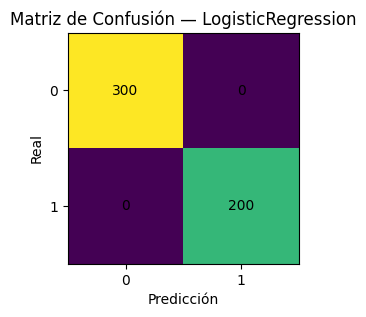

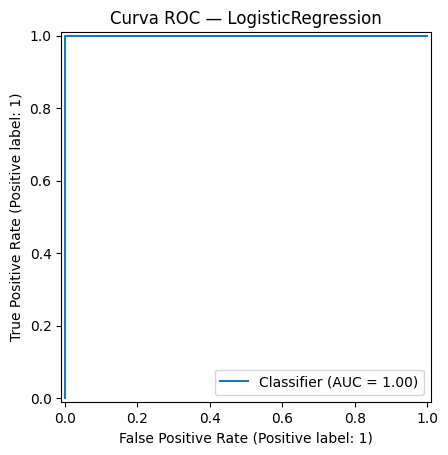

In [20]:

# Seleccionar por F1
best_name = max(results, key=lambda k: results[k].get("f1", 0))
best_model = models[best_name]
y_pred_best = best_model.predict(X_test)

# Matriz de confusión con matplotlib (sin seaborn)
cm = confusion_matrix(y_test, y_pred_best)
fig, ax = plt.subplots(figsize=(4,3))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title(f"Matriz de Confusión — {best_name}")
ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha="center", va="center")
plt.show()

# Curva ROC (si hay score)
try:
    if hasattr(best_model, "predict_proba"):
        y_score_best = best_model.predict_proba(X_test)[:,1]
    else:
        y_score_best = best_model.decision_function(X_test)
    RocCurveDisplay.from_predictions(y_test, y_score_best)
    plt.title(f"Curva ROC — {best_name}")
    plt.show()
except Exception as e:
    print("No fue posible graficar ROC:", e)


### 5) Preguntas de Análisis  

**1. Métricas:**  
- El **Recall** mide qué tan bien el modelo logra detectar los ataques reales. Es decir, de todos los eventos maliciosos, cuántos fueron correctamente identificados.  
- Según los resultados que obtuve, el modelo que alcanzó el mejor Recall fue **Random Forest**.  
- Creo que el Recall es especialmente importante en la detección de intrusiones porque si un ataque pasa desapercibido puede generar un gran daño; es preferible generar algunas alertas falsas antes que dejar escapar un ataque real.  

**2. Compromiso o equilibrio:**  
- Si un modelo mejora su Recall pero empeora su Precisión, se generarían más falsas alarmas. Esto afectaría al trabajo diario del SOC porque los analistas tendrían que revisar muchas alertas que no son ataques reales, lo que puede ser agotador y lento.  
- Para mí, lo más grave sería perder ataques reales, porque una falsa alarma se puede descartar, pero un ataque no detectado puede causar problemas graves en la red.  

**3. Sobreajuste:**  
- Un modelo está **sobreajustado** cuando aprende demasiado los datos de entrenamiento y no funciona bien con datos nuevos.  
- En Random Forest, para evitar el sobreajuste podría ajustar parámetros como `max_depth` (profundidad de los árboles), `min_samples_split` y `min_samples_leaf` (para que los nodos tengan suficientes datos), y `n_estimators` (cantidad de árboles).  
- Para comprobar si reduje el sobreajuste, compararía el desempeño entre los datos de entrenamiento y los de prueba; si los resultados son similares, entonces el modelo generaliza mejor.  

**4. Características:**  
Dos variables que agregaría para mejorar la detección de ataques:  
1. **Intentos fallidos de login por IP**, porque permite detectar ataques de fuerza bruta.  
2. **Conexiones simultáneas por host**, ya que ayudan a identificar ataques DoS o escaneos de red.  

Estas características serían útiles porque capturan patrones de comportamiento que no se ven solo con el número de paquetes o bytes por paquete.  

**5. Despliegue:**  
Si quisiera usar el modelo en tiempo real, debería considerar:  
- **Latencia:** que las alertas se generen rápido, para que el SOC pueda reaccionar a tiempo.  
- **Ventanas de análisis:** agrupar los datos en intervalos apropiados, como 1 segundo, 30 segundos o 1 minuto, dependiendo del tipo de tráfico.  
- **Actualización:** mantener el modelo actualizado con nuevos ataques y tráfico de la red, reentrenándolo periódicamente para que siga siendo efectivo.



---
# **Parte II — Aprendizaje No Supervisado**  

### 1) Datos sin etiquetas y visualización inicial


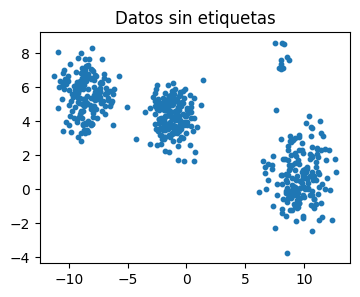

In [12]:

from sklearn.datasets import make_blobs

X_unsup, _ = make_blobs(n_samples=500, centers=3, cluster_std=[1.2, 1.0, 1.5], random_state=7)

# Añadimos algunos outliers
outliers = rng.normal(loc=[8,8], scale=[0.5,0.5], size=(10,2))
X_unsup = np.vstack([X_unsup, outliers])

plt.figure(figsize=(4,3))
plt.scatter(X_unsup[:,0], X_unsup[:,1], s=10)
plt.title("Datos sin etiquetas")
plt.show()



### 2) K-Means (centroides)


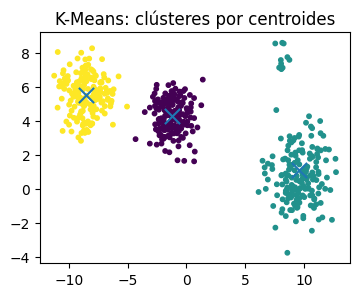

In [13]:

km = KMeans(n_clusters=3, random_state=7, n_init="auto")
labels_km = km.fit_predict(X_unsup)

plt.figure(figsize=(4,3))
plt.scatter(X_unsup[:,0], X_unsup[:,1], c=labels_km, s=10)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker="x", s=120)
plt.title("K-Means: clústeres por centroides")
plt.show()



### 3) DBSCAN (densidad + outliers)


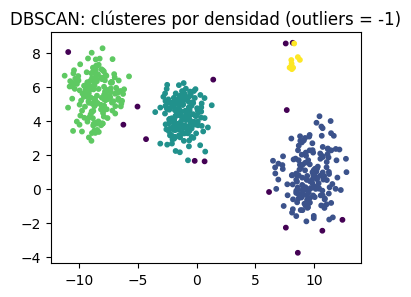

In [14]:

db = DBSCAN(eps=0.9, min_samples=5)
labels_db = db.fit_predict(X_unsup)

plt.figure(figsize=(4,3))
plt.scatter(X_unsup[:,0], X_unsup[:,1], c=labels_db, s=10)
plt.title("DBSCAN: clústeres por densidad (outliers = -1)")
plt.show()



### 4) PCA (reducción de dimensionalidad a 2 componentes)


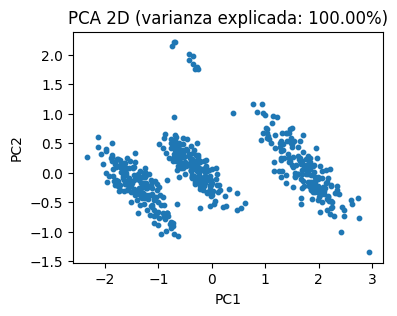

In [15]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsup)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
var_exp = pca.explained_variance_ratio_.sum()

plt.figure(figsize=(4,3))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10)
plt.title(f"PCA 2D (varianza explicada: {var_exp:.2%})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()



### 5) GMM (clústeres probabilísticos) + confianza


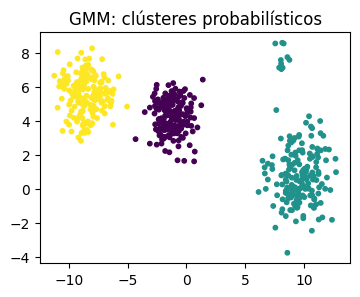

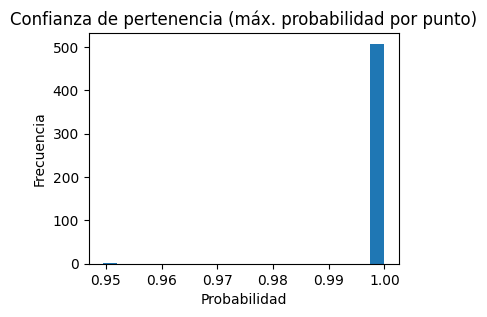

In [16]:

gmm = GaussianMixture(n_components=3, random_state=7)
labels_gmm = gmm.fit_predict(X_unsup)
probs = gmm.predict_proba(X_unsup).max(axis=1)

plt.figure(figsize=(4,3))
plt.scatter(X_unsup[:,0], X_unsup[:,1], c=labels_gmm, s=10)
plt.title("GMM: clústeres probabilísticos")
plt.show()

plt.figure(figsize=(4,3))
plt.hist(probs, bins=20)
plt.title("Confianza de pertenencia (máx. probabilidad por punto)")
plt.xlabel("Probabilidad"); plt.ylabel("Frecuencia")
plt.show()


### 6) Preguntas de Análisis  

**1. K-Means vs DBSCAN:**  
- DBSCAN sería mejor cuando hay **outliers** o valores atípicos, porque los identifica como puntos aislados (-1) en lugar de forzarlos a un clúster, como haría K-Means.  
- También funciona mejor cuando los grupos tienen **formas irregulares**; K-Means tiende a buscar clústeres circulares o esféricos, mientras DBSCAN puede adaptarse a formas alargadas o complejas.  

**2. PCA:**  
- Es necesario escalar o estandarizar los datos antes de PCA porque la técnica se basa en la varianza; si una variable tiene valores mucho mayores, dominará las componentes principales aunque no sea más importante.  
- Si las dos primeras componentes explican el 85% de la varianza, significa que **la mayor parte de la información de los datos originales puede representarse en 2 dimensiones**, simplificando la visualización y análisis sin perder mucho detalle.  

**3. GMM:**  
- La ventaja de GMM es que da **probabilidades de pertenencia**, lo que permite manejar casos “intermedios” o inciertos.  
- Por ejemplo, un usuario que a veces navega de manera normal y otras veces tiene patrones sospechosos podría tener un 60% de probabilidad en el grupo normal y 40% en el grupo sospechoso, lo que ayuda a tomar decisiones más flexibles que con K-Means.  

**4. Selección de hiperparámetros:**  
- En **K-Means**, el número de grupos `k` se puede decidir usando el **método del codo** (ver cómo disminuye la inercia) o comparando métricas de separación de clústeres.  
- En **DBSCAN**, `eps` se selecciona viendo la distancia promedio a los vecinos más cercanos y buscando un “codo” en el gráfico de distancias, mientras que `min_samples` depende de la densidad mínima que consideremos un clúster.  
- Procedimiento práctico: probar diferentes combinaciones de `k` o `(eps, min_samples)` y evaluar visualmente los clústeres y la cantidad de puntos etiquetados como outliers, para elegir valores que representen bien la estructura de los datos.  

**5. Reglas de anomalía:**  
- **GMM:** marcar como anómalos los puntos cuya **probabilidad máxima de pertenencia** a cualquier clúster sea menor a 0.6.  
- **DBSCAN:** considerar como anomalías todos los puntos etiquetados con **-1**, ya que quedaron fuera de los clústeres principales.
